In [1]:
from utils import (
    get_url, download_data, load_data, build_time_components, 
    summarize_data, rides_per_capita_month, summary_plots, 
    bin_ride_value, bin_by_cut_value, map_hotspot,
    grid_data, widen_grid_data, make_3d_array,
    plot_timeseries_cells, animate_gridded_data,
    add_time_components_to_gridded_data, check_stationarity_of_single_series, check_ac_structure,
    model_var, model_lstm, model_fnn, plot_var, plot_nn
) 

### **Get data**

In [2]:
url = get_url('~/.bolt/.url')

In [3]:
download_data(url)

In [4]:
demand = load_data('data/demand.csv')

In [ ]:
demand.head()

,start_lat,start_lng,end_lat,end_lng,ride_value
start_time,,,,,
2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


Spatiotemporal dataset of lat/lon coordinates of ride requests, incl. ride value and end lat/lon.

### **Explore data**

In [ ]:
summarize_data(demand)

No. ride requests = 627,210
Time range = 2022-03-01 00:00 - 2022-03-28 23:59
Min. ride value = 0.11
Max. ride value = 3172.70
Mean. ride value = 2.26
Median. ride value = 1.06


Binning shows ride values are strongly biased towards low values (0-10 Euro). Splitting the data at 10 Euros shows most data is below this threshold

In [7]:
bin_by_cut_value(demand, cut_value=10)

No. datapoints below cut value = 626490; (99.89%)
No. datapoints above cut value = 720; (0.11%)
Perc. revenue above cut value = 44.81%


Spatiotemporal distribution of `n_rides` shows daily activity pattern (morning and evening rush hours) and strong concentration in a downtown hotspot. Slight increase from Mo. to Sa., and over the weeks of March. Last week is incomplete (!). 

**Not possible to assess/model seasonal pattern (winter-spring-summer-autumn) with just one month, as well as multi-annual trends (like city development, et.).**

Histogram for `ride_value` shows strong bias towards low values (<10 Eur). This point can be illustrated by splitting the `ride_value` range into two histograms: one for `ride_value` <10 Eur. and another for `ride_value` >10 Eur. 

Very strange to see that values above 100 Eur. are not that infrequent, even up to values of ~3k Eur. (might be cheaper to buy a car 😂) 

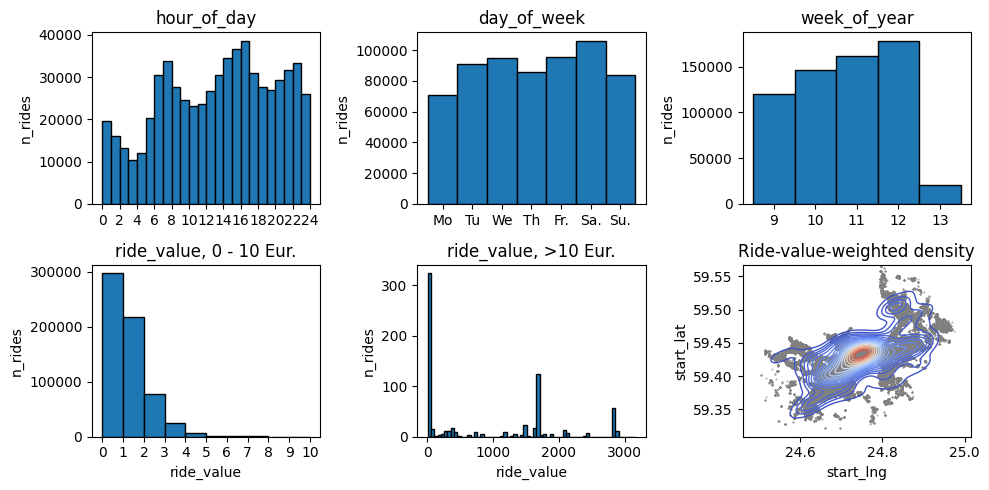

In [8]:
summary_plots(demand)

Zooming in to the downtown hotspot doesn't show any further spatial structure

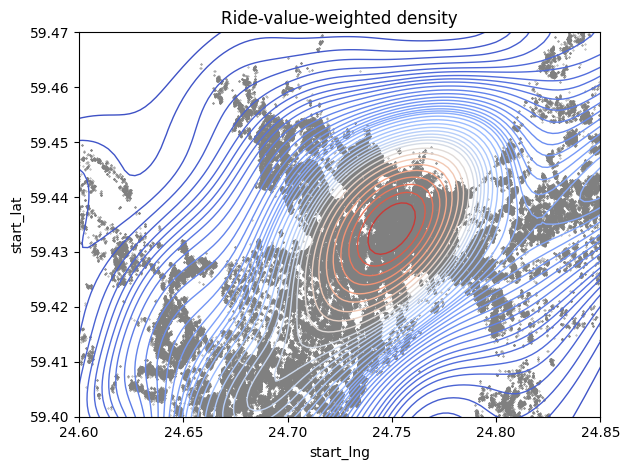

In [9]:
map_hotspot(demand)

### **Modelling approach**

The main response variables in this type of problem are `n_rides` and `ride_value`. Drivers can be allocated to high-demand zones and time periods based on both. Naturally, **drivers** will want to go to the highest `ride_value`. However, **riders** seeking low-value rides still need to get their rides.

So, in order to satisfy customers with low-value rides, **who are also the vast majority** (assuming the synthetic data are realistic), it might be better to steer drivers using `n_rides` rather than `ride_value`. **Note**: This should be done despite the fact that rides with `ride_value` > 10 Euro make up 45% of revenue, even though they represent <1% of rides (!).

However, despite this extreme revenue concentration in high-value rides, it may be harmful for the company in the long run to lure drivers towards high-value rides because that would lower the quality of the service in >99% of rides.

For this reason, the forecasting below is done using `n_rides` as a response variable.

### **Feature engineering - `n_rides`**

The original dataset...

In [10]:
demand.head(4)

,start_lat,start_lng,end_lat,end_lng,ride_value,hour_of_day,day_of_week,week_of_year,month_of_year,day_of_month
start_time,,,,,,,,,,
2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,15,6,9,3,6
2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,11,3,10,3,10
2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,14,6,9,3,6
2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,9,3,9,3,3


... is grouped into hourly, lat and lng bins ...

In [11]:
gridded_data = grid_data(demand, nrow=5, ncol=5)

In [12]:
gridded_data.head(4)

,time_bin,lat_bin,lng_bin,n_rides,mean_ride_value,min_ride_value,max_ride_value,q50_ride_vaue,q75_ride_vaue
0,2022-03-01,"(59.322, 59.371]","(24.505, 24.599]",1,3.333750,3.33375,3.33375,3.33375,3.333750
1,2022-03-01,"(59.322, 59.371]","(24.599, 24.693]",4,2.255562,1.88900,2.84725,2.14300,2.426875
2,2022-03-01,"(59.322, 59.371]","(24.693, 24.786]",1,1.072750,1.07275,1.07275,1.07275,1.072750
3,2022-03-01,"(59.322, 59.371]","(24.786, 24.88]",0,NaN,NaN,NaN,NaN,NaN


... and then converted into wide-format: columns are the time series for all the lat/lng bins, rows are time steps, index is time bin

In [13]:
gridded_data_wide = widen_grid_data(gridded_data)

In [14]:
gridded_data_wide.head(4)

,"lat_bin_(59.322, 59.371]_lng_bin_(24.505, 24.599]","lat_bin_(59.322, 59.371]_lng_bin_(24.599, 24.693]","lat_bin_(59.322, 59.371]_lng_bin_(24.693, 24.786]","lat_bin_(59.322, 59.371]_lng_bin_(24.786, 24.88]","lat_bin_(59.322, 59.371]_lng_bin_(24.88, 24.974]","lat_bin_(59.371, 59.42]_lng_bin_(24.505, 24.599]","lat_bin_(59.371, 59.42]_lng_bin_(24.599, 24.693]","lat_bin_(59.371, 59.42]_lng_bin_(24.693, 24.786]","lat_bin_(59.371, 59.42]_lng_bin_(24.786, 24.88]","lat_bin_(59.371, 59.42]_lng_bin_(24.88, 24.974]",...,"lat_bin_(59.469, 59.518]_lng_bin_(24.505, 24.599]","lat_bin_(59.469, 59.518]_lng_bin_(24.599, 24.693]","lat_bin_(59.469, 59.518]_lng_bin_(24.693, 24.786]","lat_bin_(59.469, 59.518]_lng_bin_(24.786, 24.88]","lat_bin_(59.469, 59.518]_lng_bin_(24.88, 24.974]","lat_bin_(59.518, 59.567]_lng_bin_(24.505, 24.599]","lat_bin_(59.518, 59.567]_lng_bin_(24.599, 24.693]","lat_bin_(59.518, 59.567]_lng_bin_(24.693, 24.786]","lat_bin_(59.518, 59.567]_lng_bin_(24.786, 24.88]","lat_bin_(59.518, 59.567]_lng_bin_(24.88, 24.974]"
time_bin,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,1,4,1,0,0,0,49,39,6,1,...,0,0,0,8,6,0,0,0,2,0
2022-03-01 01:00:00,0,0,1,0,0,2,33,30,5,1,...,0,0,0,8,0,0,0,0,0,0
2022-03-01 02:00:00,0,2,1,0,0,0,33,24,3,0,...,0,0,0,6,4,0,0,0,3,0
2022-03-01 03:00:00,0,4,0,0,0,1,19,21,2,3,...,0,0,0,3,2,0,0,0,0,0


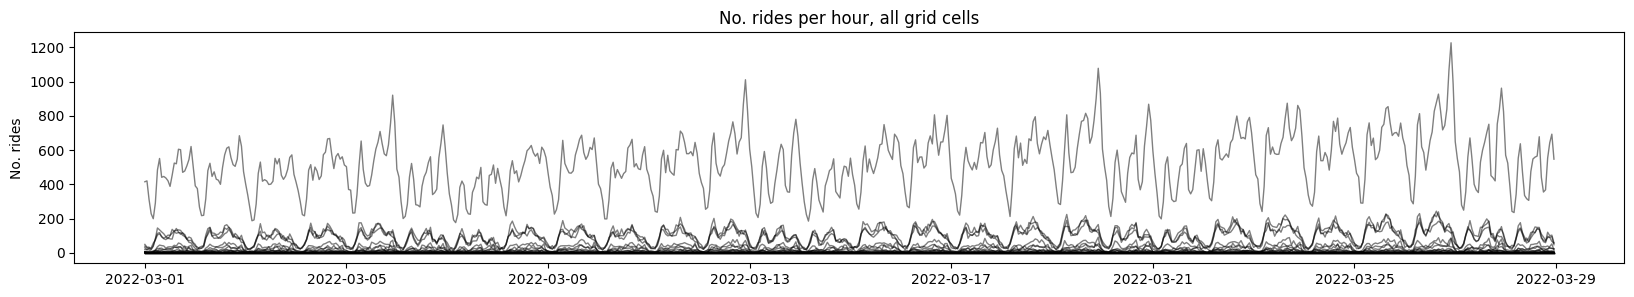

In [15]:
plot_timeseries_cells(gridded_data)

In [16]:
#animate_gridded_data(gridded_data)

In [17]:
add_time_components_to_gridded_data(gridded_data)

### **Check stationarity**

In [18]:
check_stationarity_of_single_series(gridded_data, 0, 0)

ADF Statistic: -24.10
p-value: 0.00


Over the long-term (> month), the data seems stationary. However, there are very clear small-scale seasonal patterns: daily, weekly, and possibly also seasonally (> month, < year). However, these cannot be determined because the data spans only one month. 

In the modelling below, small-scale seasonality is included simply by allowing the models to have an observation window (in VAR: `maxlags`, in LSTM: `sample_size`) that is longer than seasonal cycles (e.g., if we have hourly data and expect daily cycle, the window should be > 24 units, i.e., >24 hours). I also explored creating dummy variables to capture seasonal effects (`hour_of_day`, `day_of_week`, etc.), but results were the same.

### **Check autocorrelation (ACF) and partial autocorrelation function (PACF)**

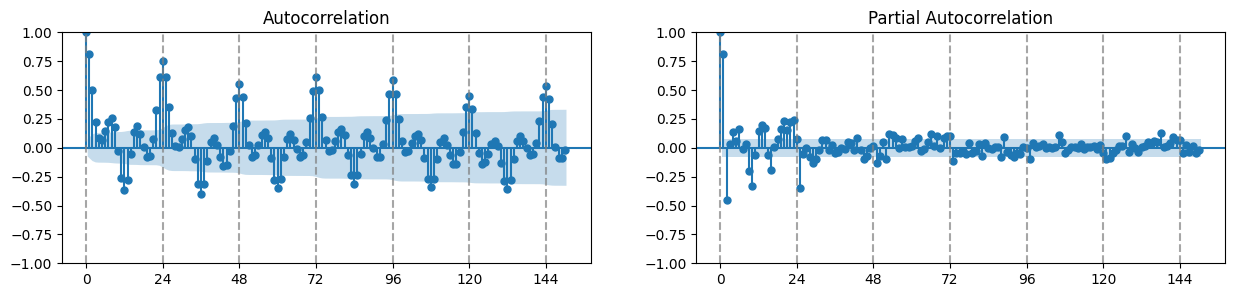

In [19]:
check_ac_structure(gridded_data, i=2, j=2)

The ACF confirms seasonality: there are significant peaks at lags 1h, 2h, 24h, 48h, 72h, ... At the same time: 

- The ACF exhibits a **tapering pattern** around each seasonal peak (as opposed to an abrupt drop)
- The PACF shows significant peaks **only** around the seasonal cycles, and then drops to the non-significant region

This combination suggests a **seasonal autorregressive process**.

### **Modelling approach 1: Vector Autoregressive Model VAR**

*Shumway & Stoffer (2011). Time Series Analysis and Its Applications*

Example with two time series $x_1$ and $x_2$:

$x_{t,1} = \alpha_1 + \phi_{1,1} x_{t-1, 1} + \phi_{1,2} x_{t-1, 2} +  w_{t, 1}$

$x_{t,2} = \alpha_2 + \phi_{2,1} x_{t-1, 1} + \phi_{2,2} x_{t-1, 2} +  w_{t, 2}$

In [20]:
results_var = model_var(gridded_data_wide, split=24*10, maxlags=24)

15,025 params. on 10,800 datapoints


#### Assess results on **chronological test set** (last 240 timesteps)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rmse_cells = np.sqrt(1/results_var['test'].shape[0] * np.sum( (results_var['test'] - results_var['forecast']) ** 2, axis=0)) 

rmse_cells

lat_bin_(59.322, 59.371]_lng_bin_(24.505, 24.599]      2181.931301
lat_bin_(59.322, 59.371]_lng_bin_(24.599, 24.693]     37522.953386
lat_bin_(59.322, 59.371]_lng_bin_(24.693, 24.786]     13035.236571
lat_bin_(59.322, 59.371]_lng_bin_(24.786, 24.88]       4929.106003
lat_bin_(59.322, 59.371]_lng_bin_(24.88, 24.974]          0.000000
lat_bin_(59.371, 59.42]_lng_bin_(24.505, 24.599]       4498.687165
lat_bin_(59.371, 59.42]_lng_bin_(24.599, 24.693]      22471.297187
lat_bin_(59.371, 59.42]_lng_bin_(24.693, 24.786]     195176.802089
lat_bin_(59.371, 59.42]_lng_bin_(24.786, 24.88]      106943.481975
lat_bin_(59.371, 59.42]_lng_bin_(24.88, 24.974]       12085.643090
lat_bin_(59.42, 59.469]_lng_bin_(24.505, 24.599]       7104.691531
lat_bin_(59.42, 59.469]_lng_bin_(24.599, 24.693]      23657.124217
lat_bin_(59.42, 59.469]_lng_bin_(24.693, 24.786]     127054.392827
lat_bin_(59.42, 59.469]_lng_bin_(24.786, 24.88]       72015.254196
lat_bin_(59.42, 59.469]_lng_bin_(24.88, 24.974]       56084.65

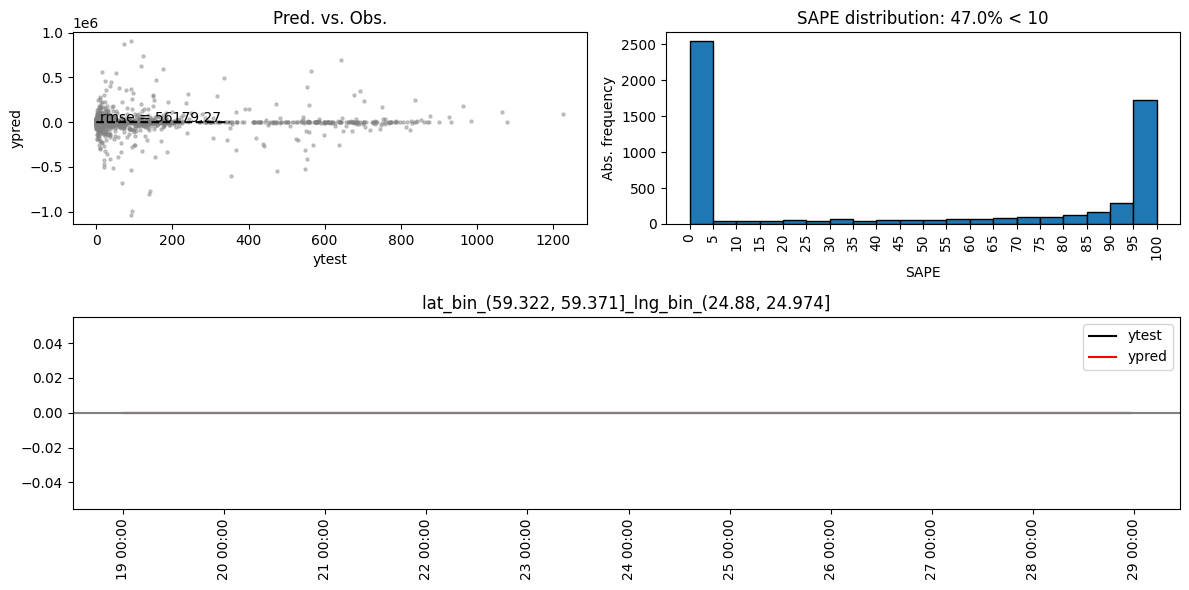

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_var(results, error_threshold, cell):

    fig = plt.figure(figsize=(12, 6))

    gs = fig.add_gridspec(2, 2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.scatter(results['ytest'], results['ypred'], color='gray', s=5, alpha=0.4)
    ax0.plot([0, 350], [0, 350], 'k--')
    ax0.set_title('Pred. vs. Obs.')
    ax0.set_xlabel('ytest')
    ax0.set_ylabel('ypred')
    ax0.text(x=10, y=300, s=f"rmse = {results['rmse']:.2f}") 

    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title(f"{results['gridded_data_wide'].columns[cell]}")
    ax2.plot(results['test'].iloc[:, cell], 'k-', label='ytest')
    ax2.plot(results['test'].index, results['forecast'][:, cell], 'r-', label='ypred')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    ax2.tick_params(axis='x', rotation=90)
    ax2.axhline(y=0, color='gray')
    ax2.legend()

    sape_bins = np.arange(0, 105, 5)
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.set_title(f'SAPE distribution: {100.0*len(results['sape'][results['sape'] < error_threshold])/len(results['sape']):.1f}% < {error_threshold}')
    ax1.hist(results['sape'], bins=sape_bins, edgecolor='black')
    ax1.set_xticks(sape_bins)
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('SAPE')
    ax1.set_ylabel('Abs. frequency')
    
    plt.tight_layout()
    plt.show()


plot_var(results_var, error_threshold=10, cell=4)

### **Modelling approach 2: LSTM**

In [36]:

def model_lstm(gridded_data_wide, test_size, sample_size):

    train_size = len(gridded_data_wide) - test_size

    gridded_data_wide_train = gridded_data_wide[:train_size]
    gridded_data_wide_test = gridded_data_wide[train_size:]

    scaler = StandardScaler()
    gridded_data_wide_train_scaled = scaler.fit_transform(gridded_data_wide_train)
    gridded_data_wide_test_scaled = scaler.transform(gridded_data_wide_test)

    Xtrain, ytrain, Xtest, ytest  = [], [], [], []

    for i in range(gridded_data_wide_train_scaled.shape[0] - sample_size):
        Xtrain.append(gridded_data_wide_train_scaled[i:i + sample_size])
        ytrain.append(gridded_data_wide_train_scaled[i + sample_size])

    for i in range(gridded_data_wide_test.shape[0] - sample_size):
        Xtest.append(gridded_data_wide_test_scaled[i:i + sample_size])
        ytest.append(gridded_data_wide_test_scaled[i + sample_size])

    Xtrain, ytrain, Xtest, ytest = np.array(Xtrain), np.array(ytrain), np.array(Xtest), np.array(ytest)

    n_features = gridded_data_wide.shape[1]

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(sample_size, n_features)),
        tf.keras.layers.LSTM(10, 'relu'),
        tf.keras.layers.Dense(n_features)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(Xtrain, ytrain, epochs=8, batch_size=20, validation_split=0.1, verbose=0)

    ypred = model.predict(Xtest)

    ypred_original = scaler.inverse_transform(ypred)
    ytest_original = scaler.inverse_transform(ytest)

    ypred_original_flattened = ypred_original.flatten()
    ytest_original_flattened = ytest_original.flatten()

    rmse = root_mean_squared_error(ytest_original, ypred_original)
    sape = compute_sape(ypred_original_flattened, ytest_original_flattened) 
    
    print(f'{model.count_params():,} params. on {Xtrain.size:,} datapoints')

    return {
        'rmse': rmse, 
        'model_fit': model, 
        'history': history, 
        'ypred': ypred_original, 
        'ytest': ytest_original,
        'gridded_data_wide': gridded_data_wide,
        'sape': sape,
    }


results_lstm = model_lstm(gridded_data_wide, test_size=24*10, sample_size=2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
1,715 params. on 21,500 datapoints


#### Assess results on **chronological test set** (last 240 timesteps)

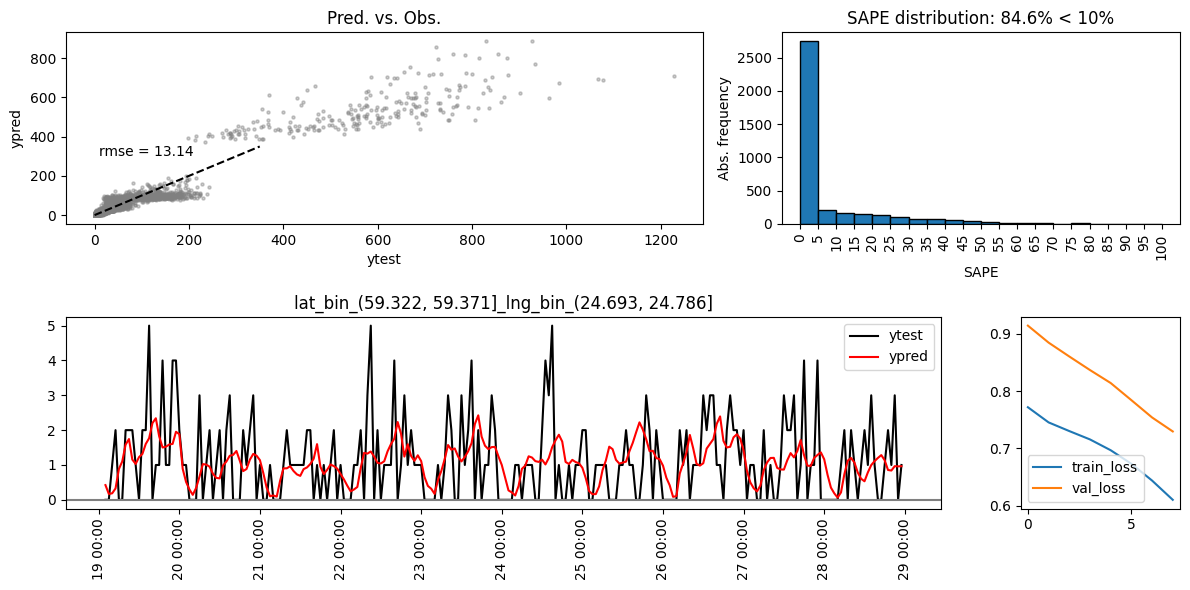

In [38]:
def plot_nn(results, error_threshold, cell):

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 5)

    ax0 = fig.add_subplot(gs[0, :3])
    ax0.scatter(results['ytest'], results['ypred'], color='gray', s=5, alpha=0.4)
    ax0.plot([0, 350], [0, 350], 'k--')
    ax0.set_title('Pred. vs. Obs.')
    ax0.set_xlabel('ytest')
    ax0.set_ylabel('ypred')
    ax0.text(x=10, y=300, s=f"rmse = {results['rmse']:.2f}") 

    sape_bins = np.arange(0, 105, 5)
    ax1 = fig.add_subplot(gs[0, 3:])
    ax1.set_title(f'SAPE distribution: {100.0*len(results['sape'][results['sape'] < error_threshold])/len(results['sape']):.1f}% < {error_threshold}%')
    ax1.hist(results['sape'], bins=sape_bins, edgecolor='black')
    ax1.set_xticks(sape_bins)
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('SAPE')
    ax1.set_ylabel('Abs. frequency')

    ax2 = fig.add_subplot(gs[1, :4])
    ax2.set_title(f"{results['gridded_data_wide'].columns[cell]}")
    ax2.plot(results['gridded_data_wide'].iloc[-len(results['ytest']):, cell], 'k-', label='ytest')
    ax2.plot(results['gridded_data_wide'].iloc[-len(results['ytest']):, cell].index, results['ypred'][:, cell], 'r-', label='ypred')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    ax2.tick_params(axis='x', rotation=90)
    ax2.axhline(y=0, color='gray')
    ax2.legend()

    ax3 = fig.add_subplot(gs[1, 4:])
    ax3.plot(results['history'].history['loss'], label='train_loss')
    ax3.plot(results['history'].history['val_loss'], label='val_loss')
    ax3.legend()    
    
    plt.tight_layout()
    plt.show()

plot_nn(results_lstm, error_threshold=10, cell=2)

### **Modelling approach 3: FNN on lagged dataset**

In [34]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import root_mean_squared_error


def compute_sape(ypred, ytest):
    '''
    Compute symmetrical absolute percentage errors
    '''

    def smape_i(ypred_i, ytest_i):
        if (ypred_i != 0.0) & (ytest_i != 0.0):
            return 100.0 * ((np.abs(ypred_i) - np.abs(ytest_i)) / (np.abs(ytest_i) + np.abs(ypred_i)))
        else:
            return 0.0
    return np.array(list(map(smape_i, ypred, ytest)))


def weighted_mse(y_true, y_pred):
    threshold = 7.0
    high_weight = 30.0
    weights = tf.where(y_true > threshold, high_weight, 1.0)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))


def model_fnn(gridded_data_wide, test_size, lags):

    train_size = len(gridded_data_wide) - test_size

    gridded_data_wide_train = gridded_data_wide[:train_size]
    gridded_data_wide_test = gridded_data_wide[train_size:]

    scaler = StandardScaler(with_mean=True, with_std=True)
    gridded_data_wide_train_scaled = scaler.fit_transform(gridded_data_wide_train)
    gridded_data_wide_test_scaled = scaler.transform(gridded_data_wide_test)

    Xtrain, ytrain = [], []
    Xtest, ytest = [], []
    maxlag = max(lags)

    for lag in lags: 
        Xtrain.append(gridded_data_wide_train_scaled[(maxlag - lag):-lag])
        Xtest.append(gridded_data_wide_test_scaled[(maxlag - lag):-lag])

    ytrain = np.array(gridded_data_wide_train_scaled[maxlag:])
    #ytrain_log = np.log2(ytrain + 1)
    
    ytest = np.array(gridded_data_wide_test_scaled[maxlag:])
    
    Xtrain = np.stack([arr for arr in Xtrain])
    Xtest = np.stack([arr for arr in Xtest])
    
    # put time steps as 1st dimension, then put all features from all lags into a single dimension
    Xtrain_transposed = Xtrain.transpose(1, 0, 2).reshape(Xtrain.shape[1], -1) 
    Xtest_transposed = Xtest.transpose(1, 0, 2).reshape(Xtest.shape[1], -1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(Xtrain_transposed.shape[1], )),
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(ytrain.shape[1], activation='linear'),
    ])

    model.compile(optimizer='adam', loss='mse')

    print(f'{model.count_params():,} params. on {Xtrain.size:,} datapoints')

    history = model.fit(Xtrain_transposed, ytrain, epochs=8, batch_size=20, validation_split=0.1, verbose=0)
    
    #ypred_log = model.predict(Xtest_transposed)
    #ypred = (2 ** ypred_log) - 1
    ypred = model.predict(Xtest_transposed)

    ypred_original = scaler.inverse_transform(ypred)
    ytest_original = scaler.inverse_transform(ytest)

    ypred_original_flattened = ypred_original.flatten()
    ytest_original_flattened = ytest_original.flatten()

    rmse = root_mean_squared_error(ytest_original_flattened, ypred_original_flattened)
    sape = compute_sape(ypred_original_flattened, ytest_original_flattened) 

    return {
        'rmse': rmse, 
        'model_fit': model, 
        'history': history, 
        'ypred': ypred_original, 
        'ytest': ytest_original,
        'gridded_data_wide': gridded_data_wide,
        'sape': sape,
    }


results_fnn = model_fnn(gridded_data_wide, test_size=24*10, lags=[12, 24, 48])

1,035 params. on 28,800 datapoints
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


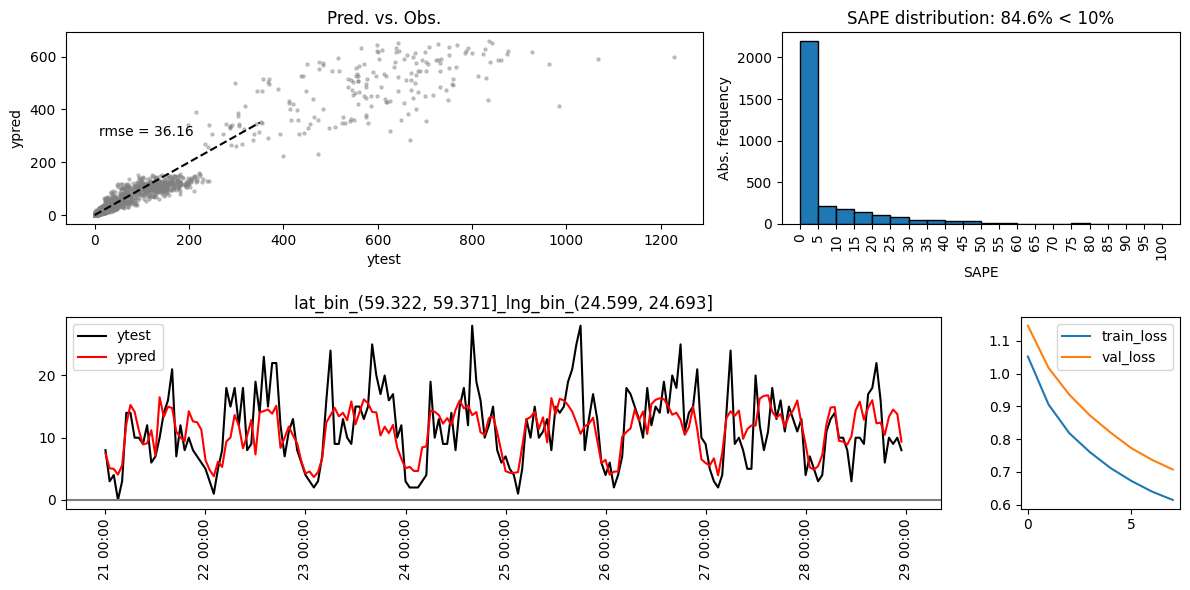

In [35]:
plot_nn(results_fnn, error_threshold=10, cell=1)

#### **Assessment**

- Overall both models good RMSE, slightly lower for VAR
- Error distribution symetrical around zero for both.
- 97% (VAR) and 96.3% (LSTM) of errors on **chronological test set**  <5 rides, good =)
- Daily trend well depicted. Need longer series to assess higher-scale trends (weekly, monthly, seasonal, multi-annual? -> sports events, big concerts, etc.)
- VAR has ~ 5 Mio. params, LSTM ~220k
- RMSE should also be assessed over space and time: group RMSE by hour, lat bin and long bin and check performance locally in space and time
- Looks like both models often miss/unterpredict hourly peaks. Must be addressed.

### **Notes**
- Only manual/intuitive optimization. In prod -> `keras tuner` or similar (focus on peaks, currently tend to be underestimated)
- Not good to have only one month, need full years to capture seasonal cycles
- `tf.keras.layers.ConvLSTM2D` with more data -> exploits spatial features *explicitly*. However, in VAR and LSTM they are used *implicitly* via cross-correlations 
- Assessing model impact in prod:
    - Expected effect: 
        - Overall better performance during rush hours and at hotspots
        - Riders spend less time finding a driver
        - Riders have shorter waiting times after finding a driver
        - Fewer unresponded ride requests (fewer times when riders don't find a driver)
        - Less idle time for drivers -> smaller time between rides
    - Experiment:
        - A/B test where we track above KPIs with and without model-driven steering
        - A/B groups must include comparable hours of the day, days of the week, weeks of the year, etc., and at comparable places given the demand distribution in the city
        - Test should include rush hours and lower-activity periods/areas 
- Model design and deployment:
    - Jupyter -> Module, include hyperparam. tuning
    - Repo -> ci/cd (`.github/workflows/cicd.yml`) -> github actions -> VM + gh runner
    - Dockerize
    - Run model as orchestrated (`airflow`) pipeline producing, e.g., weekly forecasts for the entire city. Maybe also weekly retraining as new data comes in.
    - Expose forecasts via api endpoint, e.g. `Flask`, where frontend sends desired coordinates and time and backend responds with `JSON` containing forecasted `n_rides`
- Communicate recommendations to drivers:
    - Map with simple indication of 'high demand expected here during time X'
    - Feature shows forecast for next 10 days or so 